In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

import torch.nn as nn
import torch.nn.functional as F

## 数值算例说明
我们设计一个简单的时间序列, 首先定义具有两个状态的马尔可夫过程, 转移概率矩阵为
$$
P=\left(\begin{array}{ll}
0.98 & 0.02 \\
0.02 & 0.98
\end{array}\right)
$$

再将这个马氏过程变换到二维高斯分布, 把状态0变换到
$$
\mu = \left(\begin{array}{l}
3\\4
\end{array}
\right),\quad 

\Sigma_1=\left(\begin{array}{ll}
8 & 3 \\
3 & 1.5
\end{array}\right)
$$
对应的高斯分布, 状态1对应的高斯分布均值不变, 协方差矩$\Sigma_2=R\Sigma_1 R^T$, 其中旋转矩阵$R$定义为
$$
R=\left(\begin{array}{ll}
\cos\alpha & -\sin\alpha \\
\sin\alpha & \cos\alpha
\end{array}\right)
$$


最终向量中各状态的实际数量:
状态 0: 3000
状态 1: 1500
状态 2: 500

最终向量中各状态的实际占比:
状态 0: 60.00%
状态 1: 30.00%
状态 2: 10.00%


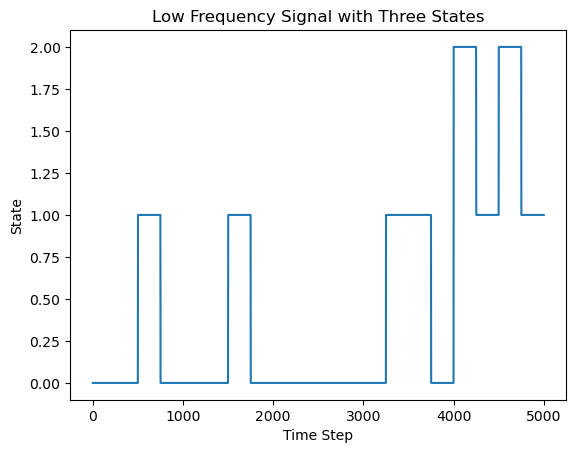

In [26]:

# 创建一个时间序列, 大致是在三个状态之间转换, 并控制转换的频率
torch.manual_seed(61)
n_steps = 5000

# 状态切换的次数, 意味着扩展成5000个点后, 大约会有20次状态切换, 保证了每段至少有250个点
num_segments = 20

# 定义三个状态的权重 (5:3:1)
weights = torch.tensor([5.0, 3.0, 1.0])

# 根据weights的权重比例随机抽取num_segments个样本
low_frequency_signal = torch.multinomial(weights, num_segments, replacement=True)

# "拉伸"低频信号, 使每段有200个点
segment_length = n_steps // num_segments
states = torch.repeat_interleave(low_frequency_signal, segment_length)

# 如果有余数，用最后一个状态的值填充，确保维度为5000
remainder = n_steps % num_segments
if remainder != 0:
    states = torch.cat([states, torch.full((remainder,), int(low_frequency_signal[-1]))])


#   计算并打印最终向量中每个状态的实际数量和占比
actual_counts = torch.bincount(states, minlength=3) # minlength=3 确保0,1,2都有计数
print("\n最终向量中各状态的实际数量:")
print(f"状态 0: {actual_counts[0].item()}")
print(f"状态 1: {actual_counts[1].item()}")
print(f"状态 2: {actual_counts[2].item()}")

actual_proportions = actual_counts.float() / n_steps
print("\n最终向量中各状态的实际占比:")
print(f"状态 0: {actual_proportions[0].item():.2%}")
print(f"状态 1: {actual_proportions[1].item():.2%}")
print(f"状态 2: {actual_proportions[2].item():.2%}")

plt.plot(states.numpy())
plt.title("Low Frequency Signal with Three States")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.show()

In [27]:
mu_0 = torch.tensor([-4,0], dtype=torch.float32)
sigma_0 = torch.tensor([[2,1.4],[1.4,1.5]], dtype=torch.float32)

mu_1 = torch.tensor([0.5,-1], dtype=torch.float32)
sigma_1 = torch.tensor([[2,-0.95],[-0.95,1]], dtype=torch.float32)

mu_2 = torch.tensor([-1.5,-3], dtype=torch.float32)
sigma_2 = torch.tensor([[2,0.1],[0.1,0.1]], dtype=torch.float32)

In [28]:
torch.manual_seed(61)

dist_0 = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=sigma_0)
dist_1 = torch.distributions.MultivariateNormal(loc=mu_1, covariance_matrix=sigma_1)
dist_2 = torch.distributions.MultivariateNormal(loc=mu_2, covariance_matrix=sigma_2)


torch.manual_seed(101) # 使用一个不同的种子

# 创建一个空的张量来存放最终结果
Xt = torch.empty(n_steps, 2, dtype=torch.float32)

# 使用布尔掩码(boolean masking)进行高效采样和赋值，避免使用for循环
# 1. 找出状态为0的所有位置
mask_0 = (states == 0)
# 2. 在这些位置上，填充从第一个分布中抽取的样本
#    mask_0.sum() 会计算出需要抽取多少个样本
Xt[mask_0] = dist_0.sample((mask_0.sum(),))

# 对状态1和状态2重复此操作
mask_1 = (states == 1)
Xt[mask_1] = dist_1.sample((mask_1.sum(),))

mask_2 = (states == 2)
Xt[mask_2] = dist_2.sample((mask_2.sum(),))


print("最终输出的维度:", Xt.shape)

最终输出的维度: torch.Size([5000, 2])


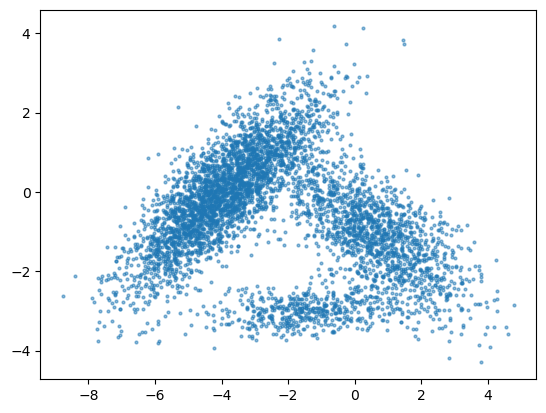

In [29]:
plt.plot(Xt[:,0], Xt[:,1], 'o', markersize=2, alpha=0.5)

In [30]:
# Random Fourier Feature

def sample_rff_gaussian(d, p, sigma):
    """ Draw a sample from the spectral density for a Gaussian kernel.
    Parameters:
    -----------
    d, int:         dimension of the state space for Gaussian kernel
    p, int:         number of samples from spectral density
    sigma, float:   bandwidth of the Gaussian kernel

    Returns:
    --------
    Omega (d, p):   p samples drawn from d-dimensional spectral density

    """

    return (1.0 / sigma) * np.random.randn(d, p)


def M_RFF_Koopman(X, Omega):
    
    phase = np.dot(X, Omega)  # shape: (n_steps, p)
    
    # 分别计算RFF的实部和虚部
    cos_features = np.cos(phase)  # shape: (n_steps, p)
    sin_features = np.sin(phase)  # shape: (n_steps, p)
    
    M = np.hstack([cos_features, sin_features])  # shape: (n_steps, 2*p)
    
    return M.T


In [31]:
# 用RFF变换Xt
d = Xt.shape[1]
p = 20   # RFF的基函数个数
sigma = 2

omega = sample_rff_gaussian(d, p, sigma)
transformed_Xt = M_RFF_Koopman(Xt, omega)

print(transformed_Xt.shape)  # (2*p, n_steps)

(40, 5000)


In [32]:
# PCA Whitening, 加入特征函数1(x)

from scipy.linalg import eigh

def whitening_transform_pca(PhiX, tol, rmin=0):
    
    # centering the data
    
    mean_vec = np.mean(PhiX, axis=1, keepdims=True)
    X_centered = PhiX - mean_vec
    
    
    # covariance matrix
    cov_matrix = np.cov(X_centered)  
    
    # eigen decomposition
    eigenvalues, eigenvectors = eigh(cov_matrix)
    
    # sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # truncation
    ind = np.where(eigenvalues / eigenvalues[0] >= tol**2)[0]
    r = np.maximum(len(ind), rmin)
    
    selected_eigenvalues = eigenvalues[:r]
    selected_eigenvectors = eigenvectors[:, :r]
    
    # Whitening matrix
    L = selected_eigenvectors * (selected_eigenvalues**(-0.5))[None, :]
    
    return L, mean_vec

# 进行PCA Whitening
L_pca, mean_pca = whitening_transform_pca(transformed_Xt, tol=1e-4, rmin=0)
whitened_Xt = L_pca.T @ (transformed_Xt - mean_pca)

print(whitened_Xt.shape)  # (r, 10000)

(33, 5000)


In [33]:
# 验证协方差矩阵
cov_original = np.cov(transformed_Xt)
cov_whitened = np.cov(whitened_Xt)

print("RFF后协方差矩阵阶数: ", cov_original.shape)
print("白化变换后协方差矩阵阶数: ", cov_whitened.shape)

print("协方差矩阵对角线元素:", np.diag(cov_whitened))
print("协方差矩阵非对角线元素最大值:", np.max(np.abs(cov_whitened - np.diag(np.diag(cov_whitened)))))

RFF后协方差矩阵阶数:  (40, 40)
白化变换后协方差矩阵阶数:  (33, 33)
协方差矩阵对角线元素: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
协方差矩阵非对角线元素最大值: 3.48541699824765e-10


In [34]:
# 加入特征函数1(x)

first_feature = np.ones(whitened_Xt.shape[1])
whitened_Xt = np.vstack([first_feature, whitened_Xt])
whitened_Xt.shape

(34, 5000)

In [35]:
# 定义L, gamma以及损失函数

class nonstation_generator(nn.Module):
    def __init__(self, n_features, n_steps, K, hidden_dim=64):
        super().__init__()
        
        self.n_features = n_features
        self.n_steps = n_steps
        self.K = K
        
        # generator function L
        self.L = nn.Parameter(
            torch.randn(K, n_features, n_features) * 0.01  
        )
        
        # affiliation function gamma(t) 
        self.gamma_network = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, K)
        )         
    
    def forward(self, whitened_Xt):

        L = self.L
        
        time_points = torch.linspace(0, 1, self.n_steps).unsqueeze(-1)  # (n_steps, 1)
        gamma_logits = self.gamma_network(time_points)  # (n_steps, K)
        gamma = F.softmax(gamma_logits, dim=-1).T  
        
        return L, gamma

def koopman_loss_function(whitened_Xt, L, gamma, epsilon_gamma=0.1, epsilon_L=0.1):
    
    n_features, n_steps = whitened_Xt.shape
    K = L.shape[0]
    
    # 计算phi(x_n)和phi(x_n+1)
    phi_t = whitened_Xt[:, :-1]   # (n_features, n_steps-1)
    phi_t1 = whitened_Xt[:, 1:]   # (n_features, n_steps-1)
    
    phi_t_batch = phi_t.T.unsqueeze(0).expand(K, -1, -1)      # (K, n_steps-1, n_features)
    phi_t1_batch = phi_t1.T.unsqueeze(0).expand(K, -1, -1)    # (K, n_steps-1, n_features)
    
    predictions = torch.bmm(phi_t_batch, L)  # (K, n_steps-1, n_features)*(K, n_features, n_features) -> (K, n_steps-1, n_features)
    
    # norm(phi_n+1, L*phi_n)
    errors = phi_t1_batch - predictions
    squared_errors = torch.sum(errors**2, dim=-1)  # (K, n_steps-1)
    
    # \|\phi(x_{n+1})-L\phi(x_n)\|^2
    main_loss = (1/(n_steps-1)) * torch.sum(squared_errors * gamma[:, :-1])
    
    # 正则化项
    smoothness_loss = epsilon_gamma * (1/(n_steps-1)) * torch.sum((gamma[:, 1:] - gamma[:, :-1])**2)
    generator_loss = epsilon_L * torch.norm(L, p='fro')**2
    
    return main_loss + smoothness_loss + generator_loss

def train_koopman_model(whitened_Xt, K, max_iter=1000, lr=1e-3, epsilon_gamma=0.01, epsilon_L=0.1):
    
    whitened_Xt = torch.tensor(whitened_Xt, dtype=torch.float32)
    
    # 初始化模型
    n_features, n_steps = whitened_Xt.shape
      
    model = nonstation_generator(n_features, n_steps, K)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # 训练
    for iteration in range(max_iter):
        optimizer.zero_grad()
        
        # 前向传播得到L和gamma(t)
        L, gamma = model(whitened_Xt)
        
        # 计算损失
        loss = koopman_loss_function(whitened_Xt, L, gamma, epsilon_gamma, epsilon_L)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印损失
        if iteration % 50 == 0:
            print(f"Iteration {iteration}: Loss = {loss.item():.6f}")
            
    
    return L.detach().numpy(), gamma.detach().numpy()


    

In [36]:
# 测试
K=3
L_final, gamma_final = train_koopman_model(whitened_Xt, K)

Iteration 0: Loss = 34.171223
Iteration 50: Loss = 33.134132
Iteration 100: Loss = 32.509083
Iteration 150: Loss = 32.030369
Iteration 200: Loss = 31.800386
Iteration 250: Loss = 31.654921
Iteration 300: Loss = 31.554970
Iteration 350: Loss = 31.487904
Iteration 400: Loss = 31.441257
Iteration 450: Loss = 31.405989
Iteration 500: Loss = 31.377083
Iteration 550: Loss = 31.352619
Iteration 600: Loss = 31.331942
Iteration 650: Loss = 31.314581
Iteration 700: Loss = 31.300060
Iteration 750: Loss = 31.287952
Iteration 800: Loss = 31.277863
Iteration 850: Loss = 31.269480
Iteration 900: Loss = 31.262527
Iteration 950: Loss = 31.256775


In [37]:
L_final.shape, gamma_final.shape

((3, 34, 34), (3, 5000))

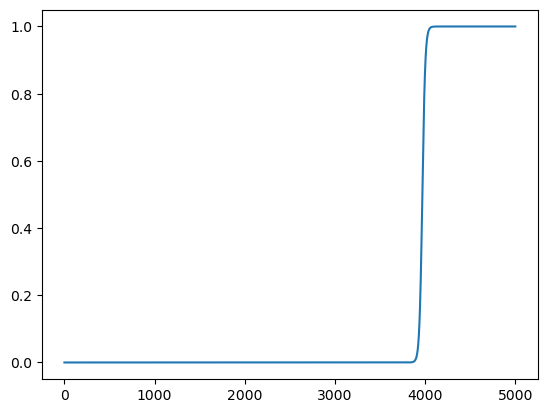

In [40]:
plt.plot(np.arange(n_steps), gamma_final[2,:].T)

class MarkovChain:
    def __init__(self, transition_matrix):
        """
        初始化马尔可夫链
        Args:
            transition_matrix: 转移概率矩阵 (n_states x n_states)
        """
        self.transition_matrix = torch.tensor(transition_matrix, dtype=torch.float32)
        self.n_states = self.transition_matrix.shape[0]
        
    def simulate(self, initial_state, n_steps):
        """
        模拟马尔可夫链
        Args:
            initial_state: 初始状态 (0 or 1)
            n_steps: 模拟步数
        Returns:
            states: 状态序列
        """
        states = [initial_state]
        current_state = initial_state
        
        for _ in range(n_steps-1):
            # 获取当前状态的转移概率
            probs = self.transition_matrix[current_state]
            # 根据概率分布采样下一个状态
            next_state = torch.multinomial(probs, 1).item()
            states.append(next_state)
            current_state = next_state
            
        return states
    
    def get_stationary_distribution(self):
        """
        计算稳态分布
        Returns:
            stationary_dist: 稳态概率分布
        """
        # 通过求解 π = πP 来找到稳态分布
        # 等价于求解 (P^T - I)π = 0 的非零解
        P_T = self.transition_matrix.T
        A = P_T - torch.eye(self.n_states)
        # 添加归一化约束：所有概率之和为1
        A = torch.vstack([A[:-1], torch.ones(1, self.n_states)])
        b = torch.zeros(self.n_states)
        b[-1] = 1.0
        
        # 求解线性方程组
        stationary_dist = torch.linalg.solve(A.T @ A, A.T @ b)
        return stationary_dist
    
    def n_step_transition(self, n):
        """
        计算n步转移概率矩阵
        Args:
            n: 步数
        Returns:
            n_step_matrix: n步转移矩阵
        """
        return torch.matrix_power(self.transition_matrix, n)

# 定义转移概率矩阵
transition_matrix = [[0.98, 0.02],
                    [0.02, 0.98]]

# 创建马尔可夫链实例
mc = MarkovChain(transition_matrix)

print("转移概率矩阵:")
print(mc.transition_matrix)
print()

# 计算稳态分布(直接根据转移概率矩阵算)
stationary_dist = mc.get_stationary_distribution()
print("稳态分布:")
print(f"状态0: {stationary_dist[0]:.4f}")
print(f"状态1: {stationary_dist[1]:.4f}")
print()

# 模拟马尔可夫链
n_steps = 10000
initial_state = 0

# 设置随机种子以获得可重现的结果
torch.manual_seed(61)
states = mc.simulate(initial_state, n_steps)

print(f"模拟 {n_steps} 步:")
print(f"初始状态: {initial_state}")
#print(f"前20步状态序列: {states[:21]}")
print()

# 计算状态频率
state_counts = torch.bincount(torch.tensor(states))
state_frequencies = state_counts.float() / len(states)
print("状态频率:")
print(f"状态0: {state_frequencies[0]:.4f}")
print(f"状态1: {state_frequencies[1]:.4f}")
print()

# 可视化状态序列
plt.figure(figsize=(12, 8))

# 子图1: 状态时间序列
plt.subplot(2, 2, 1)
plt.plot(states[:1000])  # 显示前1000步
plt.title('状态时间序列 (前1000步)')
plt.xlabel('时间步')
plt.ylabel('状态')
plt.ylim(-0.1, 1.1)
plt.grid(True)

# 子图2: 状态频率直方图
plt.subplot(2, 2, 2)
plt.bar([0, 1], state_frequencies, alpha=0.7)
plt.title('状态频率分布')
plt.xlabel('状态')
plt.ylabel('频率')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# 子图3: 累积状态比例
plt.subplot(2, 2, 3)
cumulative_prop = torch.cumsum(torch.tensor(states, dtype=torch.float32), dim=0) / torch.arange(1, len(states) + 1)
plt.plot(cumulative_prop)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='理论稳态值')
plt.title('状态1的累积比例')
plt.xlabel('时间步')
plt.ylabel('累积比例')
plt.legend()
plt.grid(True)

# 子图4: 状态转移次数
plt.subplot(2, 2, 4)
transitions = [[0, 0], [0, 0]]
for i in range(len(states) - 1):
    transitions[states[i]][states[i+1]] += 1

transitions = torch.tensor(transitions, dtype=torch.float32)
transition_probs = transitions / transitions.sum(dim=1, keepdim=True)

im = plt.imshow(transition_probs, cmap='Blues', vmin=0, vmax=1)
plt.title('观测到的转移概率')
plt.xlabel('目标状态')
plt.ylabel('起始状态')
plt.colorbar(im)

# 添加数值标签
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{transition_probs[i, j]:.3f}', 
                ha='center', va='center', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# 设计一组特征, 这里我们选择前5个Legendre多项式的张量积

from scipy.special import legendre
from numpy.polynomial.legendre import legval

def feature_mapping_Legendre(data, max_order=4):
    
    n_samples = data.shape[0]
    x_data = data[:, 0]
    y_data = data[:, 1]
    
    # 生成所有可能的(i,j)组合, (0,0), (0,1), ..., (4,4), 共25个特征映射
    orders = [(i, j) for i in range(max_order + 1) for j in range(max_order + 1)]
    n_basis = len(orders)
    
    # 计算勒让德多项式系数
    polynomials = {}
    
    standard_coeffs = {}
    for n in range(max_order + 1):
        standard_coeffs[n] = legendre(n)      # legendre(n) 返回的是标准勒让德多项式的系数, 从高到低排列
    
    transformed_data = np.zeros((n_samples, n_basis))
    # 为每个基函数计算变换值
    for idx, (i, j) in enumerate(orders):
        # 计算 P_i(x) 和 P_j(y)
        P_i_x = legval(x_data, standard_coeffs[i])
        P_j_y = legval(y_data, standard_coeffs[j])
        
        # 计算 P_i(x) * P_j(y)
        transformed_data[:, idx] = P_i_x * P_j_y
    
    # 构建基函数信息
    basis_info = [f"P_{i}(x)P_{j}(y)" for i, j in orders]
    
    return transformed_data, basis_info


# 数据变换到特征空间

transformed_Xt, basis_names = feature_mapping_Legendre(Xt, max_order=4)

print(f"原始数据形状: {Xt.shape}")
print(f"变换后数据形状: {transformed_Xt.shape}")
print(f"基函数数量: {len(basis_names)}")
print("\n基函数名称:")
for i, name in enumerate(basis_names):
    print(f"{i}: {name}")


# 用torch的梯度下降来优化参数

def optimized_koopman_learning(transformed_Xt, gamma_t, max_iter=10, lr=0.001):

    transformed_Xt = torch.tensor(transformed_Xt, dtype=torch.float32)
    gamma_t = torch.tensor(gamma_t, dtype=torch.float32, requires_grad=True)
    
    n_steps, n_features = transformed_Xt.shape
    K = gamma_t.shape[0]
    
    # 初始化L矩阵, 包括了K个不同模态对应的generator
    L = torch.randn(K, n_features, n_features, requires_grad=True)
    
    # 优化器, 要优化的参数是generator L和隶属度函数gamma_t
    optimizer = torch.optim.Adam([L, gamma_t], lr=lr)
    
    # 预计算数据, 避免K*n_steps的循环
    phi_t = transformed_Xt[:-1].unsqueeze(0)      # (1, n_steps-1, n_features)
    phi_t1 = transformed_Xt[1:].unsqueeze(0)      # (1, n_steps-1, n_features)
    phi_0 = transformed_Xt[0].unsqueeze(0)        # (1, n_features)
    phi_1 = transformed_Xt[1].unsqueeze(0)        # (1, n_features)
    
    for iteration in range(max_iter):
        optimizer.zero_grad()
        
        # 批量矩阵乘法：(K, n_steps-1, n_features)
        pred = torch.bmm(phi_t.expand(K, -1, -1), L.transpose(-2, -1))
        
        # 计算误差：(K, n_steps-1, n_features)
        errors = phi_t1.expand(K, -1, -1) - pred
        squared_errors = torch.sum(errors**2, dim=-1)  # (K, n_steps-1), 把特征维度做了求和
        
        # 加权损失
        main_loss = torch.sum(squared_errors * gamma_t[:, :-1])   # (K, n_steps-1)相乘, 根据隶属度函数gamma_t加权
        
        # 终点损失(Boyko论文里把终点误差设置为和起点误差相同)
        pred_end = torch.bmm(phi_0.expand(K, -1, -1), L.transpose(-2, -1))
        errors_end = phi_1.expand(K, -1, -1) - pred_end
        squared_errors_end = torch.sum(errors_end**2, dim=-1)  # (K, 1)
        end_loss = torch.sum(squared_errors_end.squeeze() * gamma_t[:, -1])
        
        # 总损失
        total_loss = main_loss + end_loss
        
        # 约束损失
        constraint_loss = torch.sum((torch.sum(gamma_t, dim=0) - 1.0)**2) * 1000
        final_loss = total_loss + constraint_loss
        
        final_loss.backward()
        optimizer.step()
        
        # 投影gamma_t
        with torch.no_grad():
            gamma_t.data = torch.clamp(gamma_t.data, min=1e-8)
            gamma_t.data = gamma_t.data / torch.sum(gamma_t.data, dim=0, keepdim=True)
        
        if iteration % 1 == 0:
            print(f"Iteration {iteration}, Loss: {total_loss.item():.6f}")
    
    return L.detach().numpy(), gamma_t.detach().numpy()

# 使用方法
L_final, gamma_t_final = optimized_koopman_learning(transformed_Xt, gamma_t, max_iter=10)


# 在这个例子中先用单项式作为基函数

# auxiliary functions, 生成按字典序排列的数组
def nchoosek(n, k):
    '''
    Computes binomial coefficients.
    '''
    return math.factorial(n)//math.factorial(k)//math.factorial(n-k) # integer division operator


def nextMonomialPowers(x):
    '''
    Returns powers for the next monomial. Implementation based on John Burkardt's MONOMIAL toolbox, see
    http://people.sc.fsu.edu/~jburkardt/m_src/monomial/monomial.html.
    '''
    m = len(x)
    j = 0
    for i in range(1, m): # find the first index j > 1 s.t. x[j] > 0
        if x[i] > 0:
            j = i
            break
    if j == 0:
        t = x[0]
        x[0] = 0
        x[m - 1] = t + 1
    elif j < m - 1:
        x[j] = x[j] - 1
        t = x[0] + 1
        x[0] = 0
        x[j-1] = x[j-1] + t
    elif j == m - 1:
        t = x[0]
        x[0] = 0
        x[j - 1] = t + 1
        x[j] = x[j] - 1
    return x


def allMonomialPowers(d, p):
    '''
    All monomials in d dimensions of order up to p.
    '''
    # Example: For d = 3 and p = 2, we obtain
    # [[ 0  1  0  0  2  1  1  0  0  0]
    #  [ 0  0  1  0  0  1  0  2  1  0]
    #  [ 0  0  0  1  0  0  1  0  1  2]]
    n = nchoosek(p + d, p) # number of monomials
    x = np.zeros(d) # vector containing powers for the monomials, initially zero
    c = np.zeros([d, n]) # matrix containing all powers for the monomials
    for i in range(1, n):
        c[:, i] = nextMonomialPowers(x)
    c = np.flipud(c) # flip array in the up/down direction
    return c

# 测试allMonomialPowers函数
allMonomialPowers(3,2)

# 定义特征基函数为p阶单项式

class monomials(object):
    '''
    Computation of monomials in d dimensions.
    '''

    def __init__(self, p):
        '''
        The parameter p defines the maximum order of the monomials.
        '''
        self.p = p

    def __call__(self, x):
        '''
        Evaluate all monomials of order up to p for all data points in x.
        '''
        [m, d] = x.shape # d = dimension of state space, m = number of test points
        c = allMonomialPowers(d, self.p) # matrix containing all powers for the monomials
        n = c.shape[1] # number of monomials
        y = np.ones([n, m])
        for i in range(n):
            for j in range(d):
                y[i, :] = y[i, :] * np.power(x[j, :], c[j, i])    # n是特征函数个数, m是样本个数, 把(d,m)维原始数据变成了(n,m)维特征数据
        return y
    
    
    
    def diff(self, x):
        '''
        Compute partial derivatives for all data points in x.
        '''
        [d, m] = x.shape # d = dimension of state space, m = number of test points
        c = allMonomialPowers(d, self.p) # matrix containing all powers for the monomials
        n = c.shape[1] # number of monomials
        y = np.zeros([n, d, m])
        for i in range(n): # for all monomials
            for j in range(d): # for all dimensions
                e = c[:, i].copy() # exponents of ith monomial
                a = e[j]
                e[j] = e[j] - 1 # derivative w.r.t. j
                
                if np.any(e < 0):
                    continue # nothing to do, already zero
                
                y[i, j, :] = a*np.ones([1, m])
                for k in range(d):
                    y[i, j, :] = y[i, j, :] * np.power(x[k, :], e[k])
        return y
    
    def ddiff(self, x):
        '''
        Compute second order derivatives for all data points in x.
        '''
        [d, m] = x.shape # d = dimension of state space, m = number of test points
        c = allMonomialPowers(d, self.p) # matrix containing all powers for the monomials
        n = c.shape[1] # number of monomials
        y = np.zeros([n, d, d, m])
        for i in range(n): # for all monomials
            for j1 in range(d): # for all dimensions
                for j2 in range(d): # for all dimensions
                    e = c[:, i].copy() # exponents of ith monomial
                    a = e[j1]
                    e[j1] = e[j1] - 1 # derivative w.r.t. j1
                    a *= e[j2]
                    e[j2] = e[j2] - 1 # derivative w.r.t. j2
                    
                    if np.any(e < 0):
                        continue # nothing to do, already zero
                    
                    y[i, j1, j2, :] = a*np.ones([1, m])
                    for k in range(d):
                        y[i, j1, j2, :] = y[i, j1, j2, :] * np.power(x[k, :], e[k])
        return y
        
    def __repr__(self):
        return 'Monomials of order up to %d.' % self.p
    
    def display(self, alpha, d, name = None, eps = 1e-6):
        '''
        Display the polynomial with coefficients alpha.
        '''
        c = allMonomialPowers(d, self.p) # matrix containing all powers for the monomials
        
        if name != None: print(name + ' = ', end = '')
        
        ind, = np.where(abs(alpha) > eps)
        k = ind.shape[0]
        
        if k == 0: # no nonzero coefficients
            print('0')
            return
        
        for i in range(k):
            if i == 0:
                print(f'{alpha[ind[i]]:.4f}', end = '')
            else:
                if alpha[ind[i]] > 0:
                    print(f' + {alpha[ind[i]]:.4f}', end = '')
                else:
                    print(f' - {-alpha[ind[i]]:.4f}', end = '')
                        
            self._displayMonomial(c[:, ind[i]])
        print('')
        
    def _displayMonomial(self, p):
        d = p.shape[0]
        if np.all(p == 0):
            print('1', end = '')
        else:
            for j in range(d):
                if p[j] == 0:
                    continue
                if p[j] == 1:
                    print(f' x_{j+1}', end = '')
                else:
                    print(f' x_{j+1}^{int(p[j])}', end = '')